# Model Performance


## Prerequisites
Install python packages

In [10]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn requests
%pip install segmentationmetrics

## Import required python packages

In [11]:
import warnings

warnings.filterwarnings("ignore")

import io
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

In [12]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

## Download the segmentation results from zenodo

In [13]:
qa_dir = Path("qa-results")

In [14]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="brain-mr.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [15]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if label in result.available_segments:
        image = result.segment_image(label)
    else:
        # create an empty image
        tmp_img = result.segment_image(list(result.available_segments)[0])
        tmp_arr = sitk.GetArrayFromImage(tmp_img)
        image = sitk.GetImageFromArray(np.zeros_like(tmp_arr))
        image.CopyInformation(tmp_img)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label == 1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)

    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(
    ai_seg_file, qa_seg_file, fname, label_value=1, version="aimiv2", label_suffix=""
):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    if label_value==1:
        tol=5
    if label_value!=1:
        tol=2
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_5": compute_surface_dice_at_tolerance(
            m._surface_dist, tol
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

In [16]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna(row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = "aimiv1" if row.AimiProjectYear == 2023 else "aimiv2"
    for label_value in [1, 2, 3]:
        metrics.append(
            calc_metrics_for_label(
                ai_file,
                qa_file,
                row.SeriesInstanceUID,
                version=version,
                label_value=label_value,
            )
        )

metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

  0%|          | 0/55 [00:00<?, ?it/s]

In [17]:
# add label names
ds = pydicom.dcmread(ai_path / df.AISegmentation.iloc[0])
result = pydicom_seg.SegmentReader().read(ds)
label_names = {
    k: v["SegmentDescription"].value for k, v in result.segment_infos.items()
}
assert len(label_names) == 3, "Only 3 labels are expected"

# update metrics_df with label names column
metrics_df["label_name"] = metrics_df["label"].map(label_names)

In [19]:
# Group by 'label' and 'version' and aggregate metrics
aggregated_df = (
    metrics_df.groupby(["label_name"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "mean_surface_distance_tol_5": ["mean", "std"],
        }
    )
    .round(2)
)

aggregated_df

dice       hausdorff_distance_95       mean_surface_distance  \
                 mean   std                  mean   std                  mean   
label_name                                                                      
edema            0.98  0.07                  1.98  4.83                  0.18   
enhancing tumor  0.95  0.13                  3.12  7.73                  0.38   
necrosis         0.96  0.16                  0.93  2.68                  0.15   

                      mean_surface_distance_tol_5        
                  std                        mean   std  
label_name                                               
edema            0.42                        0.98  0.06  
enhancing tumor  1.00                        0.95  0.13  
necrosis         0.59                        0.98  0.11

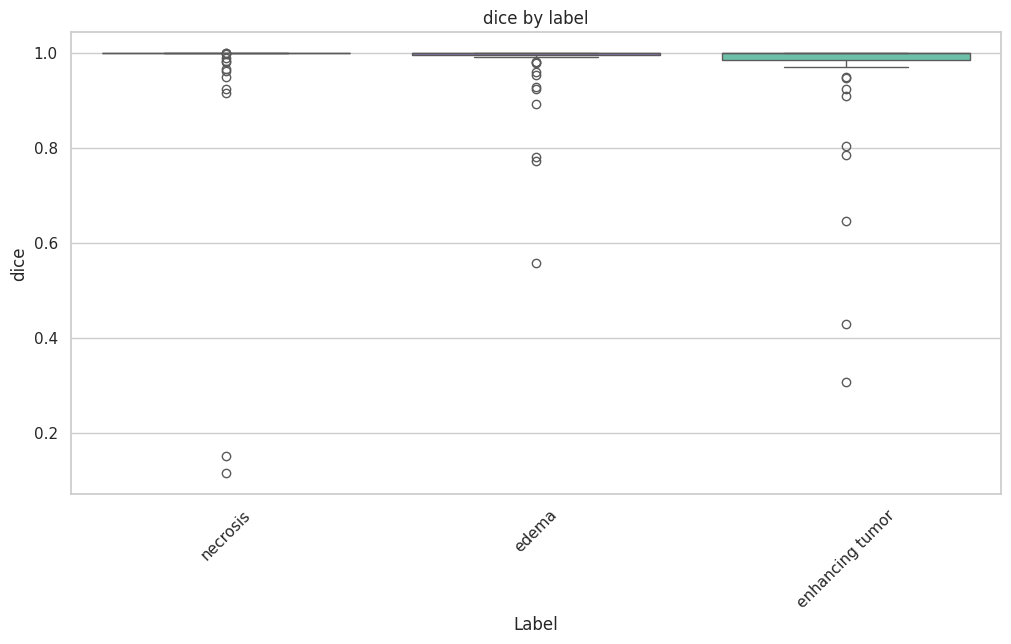

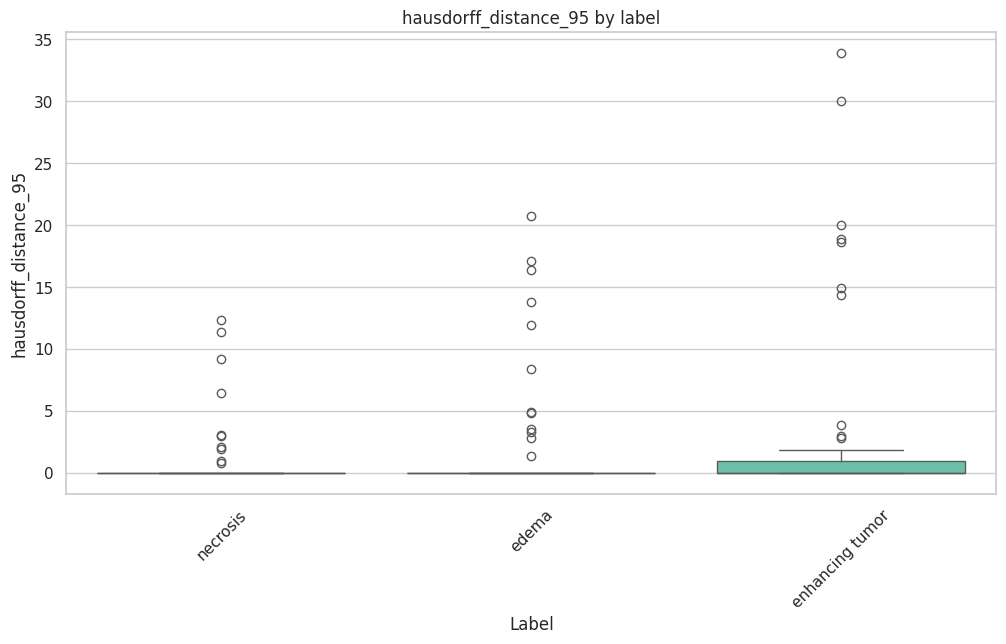

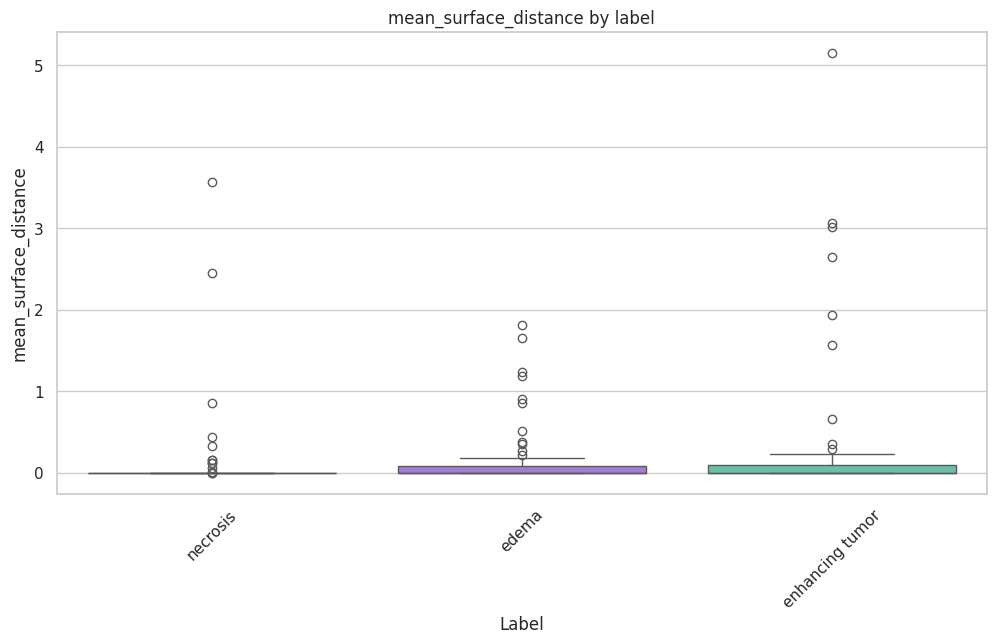

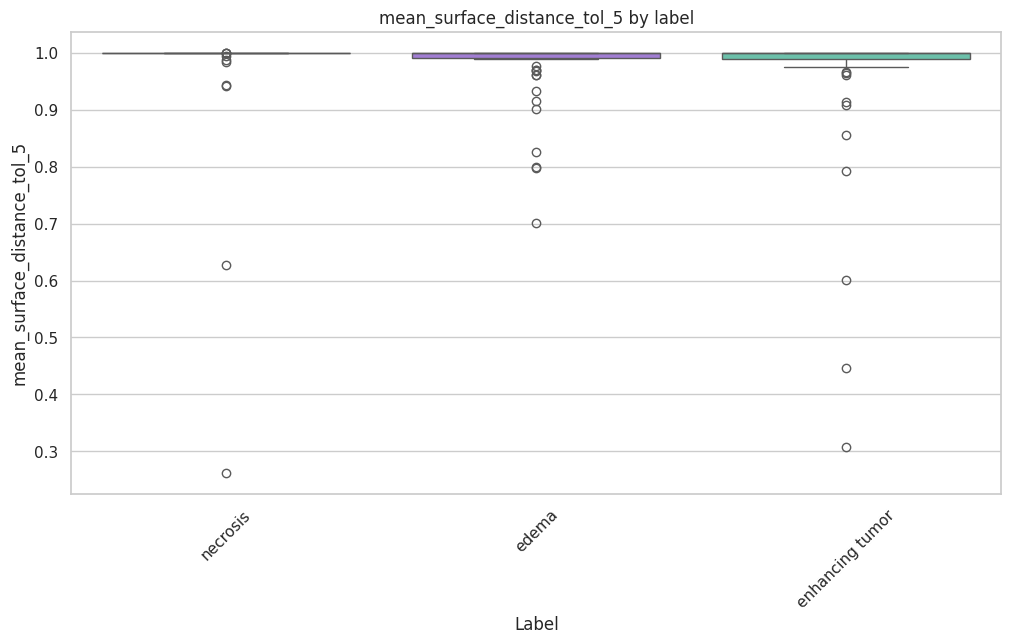

In [21]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "mean_surface_distance_tol_5",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    ax.set_title(f"{metric} by label")
    ax.set_ylabel(metric)
    ax.set_xlabel("Label")
    plt.xticks(rotation=45)
    plt.show()